In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
tfidf = TfidfVectorizer()

!pip -q install sentence_transformers
from sentence_transformers import SentenceTransformer
!pip install tensorflow

import os
from huggingface_hub import login
os.environ["HF_TOKEN"] = "token"
login(token=os.environ["HF_TOKEN"])


In [8]:
from zipfile import ZipFile
zip_path = "/content/archive.zip"
extract_path = "/content/unzipped_files"
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

df1=pd.read_csv('/content/unzipped_files/credits.csv')
df2=pd.read_csv('/content/unzipped_files/keywords.csv')
df3=pd.read_csv('/content/unzipped_files/movies_metadata.csv')


# Cleaning data and making it clean
df3.drop(['adult', 'belongs_to_collection','homepage', 'imdb_id', 'original_language', 'poster_path', 'release_date','runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video','vote_count'], axis = 1, inplace = True)
for i in [df1, df2, df3]:
    i['id'] = i['id'].astype(str)
df = df1.merge(df2, on='id', how='outer').merge(df3, on='id', how='outer')

# Setting target variable

target = df["vote_average"]


# Processing data
# extracting only the required text and important content

import ast
import pandas as pd

def extract_actor_names(cast_str):
    try:
        cast_list = ast.literal_eval(cast_str)  # safely convert string to list
        names = [member['name'] for member in cast_list[:3]]  # top 5 actors
        return ", ".join(names)
    except (ValueError, SyntaxError, KeyError, TypeError):
        return ""
import ast

def extract_directors(crew_str):
    try:
        crew_list = ast.literal_eval(crew_str)
        directors = [member['name'] for member in crew_list if member.get('job') == 'Director']
        return ", ".join(directors)
    except (ValueError, SyntaxError, TypeError):
        return ""

def extract_names(list_str, top_n=None, key='name'):
    """Convert stringified list of dicts to comma-separated names."""
    try:
        lst = ast.literal_eval(list_str)
        names = [item[key] for item in lst if key in item]
        if top_n:
            names = names[:top_n]
        return ", ".join(names)
    except (ValueError, SyntaxError, TypeError):
        return ""

def extract_names(list_str, top_n=None, key='name'):
    """Convert stringified list of dicts to comma-separated names."""
    try:
        lst = ast.literal_eval(list_str)
        names = [item[key] for item in lst if key in item]
        if top_n:
            names = names[:top_n]
        return ", ".join(names)
    except (ValueError, SyntaxError, TypeError):
        return ""

df['genres_'] = df['genres'].apply(lambda x: extract_names(x))

df['keywords_'] = df['keywords'].apply(lambda x: extract_names(x))
df['production_companies_'] = df['production_companies'].apply(lambda x: extract_names(x))
df['production_countries_'] = df['production_countries'].apply(lambda x: extract_names(x))

df['director'] = df['crew'].apply(extract_directors)

df['cast1'] = df['cast'].apply(extract_actor_names)

df.drop(['cast', 'crew', 'keywords','production_companies', 'production_countries'], axis = 1, inplace = True)


# Normalising the data

for col in ['budget', 'revenue']:
    df[col] = df[col].replace(0, df[col].median())  # replace 0 with median

df[['budget', 'popularity', 'revenue']] = (df[['budget', 'popularity', 'revenue']] - df[['budget', 'popularity', 'revenue']].min()) / (df[['budget', 'popularity', 'revenue']].max() - df[['budget', 'popularity', 'revenue']].min())

# Checking if everything matches our needs

df.head(2)



# One- Hot Encoding for genres, production_countries

# Ensure all values are strings
df['production_countries_'] = df['production_countries_'].fillna('').astype(str)

# Genres one-hot encoding
genres_dummies = df['genres_'].str.get_dummies(sep=', ')
df = pd.concat([df, genres_dummies], axis=1)
df = df.drop(columns=['genres_'])

# Production countries one-hot encoding (top 20)
top_countries = df['production_countries_'].str.split(', ').explode().value_counts().head(20).index
df['production_countries_'] = df['production_countries_'].apply(
    lambda x: ', '.join([c for c in x.split(', ') if c in top_countries])
)
countries_dummies = df['production_countries_'].str.get_dummies(sep=', ')
df = pd.concat([df, countries_dummies], axis=1)
df = df.drop(columns=['production_countries_'])


# Embedding the data using sentence transformers

# Here we are doing symantic embeddings for text data overview, cast, director and keywords

model = SentenceTransformer('all-MiniLM-L6-v2')

# Columns to convert
text_cols = ['overview', 'keywords_', 'cast1', 'director']

for col in text_cols:
    embeddings = model.encode(df[col].astype(str).tolist())
    df[col + '_emb'] = list(embeddings)

# Check the first row
print(df[['overview_emb', 'keywords__emb', 'cast1_emb', 'director_emb']].iloc[0])

df.drop(['overview', 'cast1', 'keywords_', 'director'], axis = 1, inplace = True)

# saving dataset
df.to_csv("/content/recent.csv", index=False)

# to see the data type of obgject
print(np.isnan(X).any(), np.isinf(X).any(), np.isnan(y).any(), np.isinf(y).any())


FileNotFoundError: [Errno 2] No such file or directory: '/content/archive.zip'

In [11]:
import pandas as pd

# Replace 'your_file.csv' with the actual filename
df = pd.read_csv('/content/recent.csv')

# Get number of rows
num_rows = len(df)
print("Number of rows:", num_rows)


TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

Now the neural network

Below we have the splitting and training of data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split

# Remove duplicate columns
# df = df.loc[:, ~df.columns.duplicated()]

# Numeric and embedding columns
numeric_cols = ['budget', 'popularity', 'revenue']
embedding_cols = ['overview_emb', 'keywords__emb', 'cast1_emb', 'director_emb']

# Ensure embedding columns are proper lists
embedding_size = len(df['overview_emb'].dropna().iloc[0])
for col in embedding_cols:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [0.0]*embedding_size)

# One-hot columns
one_hot_cols = [c for c in df.columns if c not in numeric_cols + embedding_cols + ['vote_average']]


# Convert numeric columns
X_numeric = df[numeric_cols].astype(np.float32).values

# Convert one-hot columns
X_onehot = df[one_hot_cols].astype(np.float32).values

# Convert embedding columns
X_overview = np.stack(df['overview_emb'].apply(np.array).values).astype(np.float32)
X_keywords = np.stack(df['keywords__emb'].apply(np.array).values).astype(np.float32)
X_cast = np.stack(df['cast1_emb'].apply(np.array).values).astype(np.float32)
X_director = np.stack(df['director_emb'].apply(np.array).values).astype(np.float32)

# Concatenate all
X = np.concatenate([X_numeric, X_onehot, X_overview, X_keywords, X_cast, X_director], axis=1)
y = df['vote_average'].astype(np.float32).values
# Split 70% train, 15% validation, 15% test

X = np.nan_to_num(X, nan=0.0)
y = np.nan_to_num(y, nan=0.0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build neural network
input_dim = X.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1)(x)  # regression output

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print("Test MAE:", mae)


Epoch 1/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.2303 - mae: 1.6126 - val_loss: 3.5671 - val_mae: 1.3010
Epoch 2/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.4423 - mae: 1.2993 - val_loss: 3.5387 - val_mae: 1.3160
Epoch 3/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4958 - mae: 1.3077 - val_loss: 3.5256 - val_mae: 1.2855
Epoch 4/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3763 - mae: 1.2824 - val_loss: 3.5528 - val_mae: 1.2790
Epoch 5/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3515 - mae: 1.2656 - val_loss: 3.5675 - val_mae: 1.3770
Epoch 6/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.3251 - mae: 1.2674 - val_loss: 3.4733 - val_mae: 1.2961
Epoch 7/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3710 - mae: 1.2796 - val_loss: 3.7462 - val_mae: 1.2638
Epoch 8/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3290 - mae: 1.2634 - val_loss: 3.5695 - val_mae: 1.3727
Epoch 9/20
1021/1021 ━━━━━━━━━━━━━━━━━━━

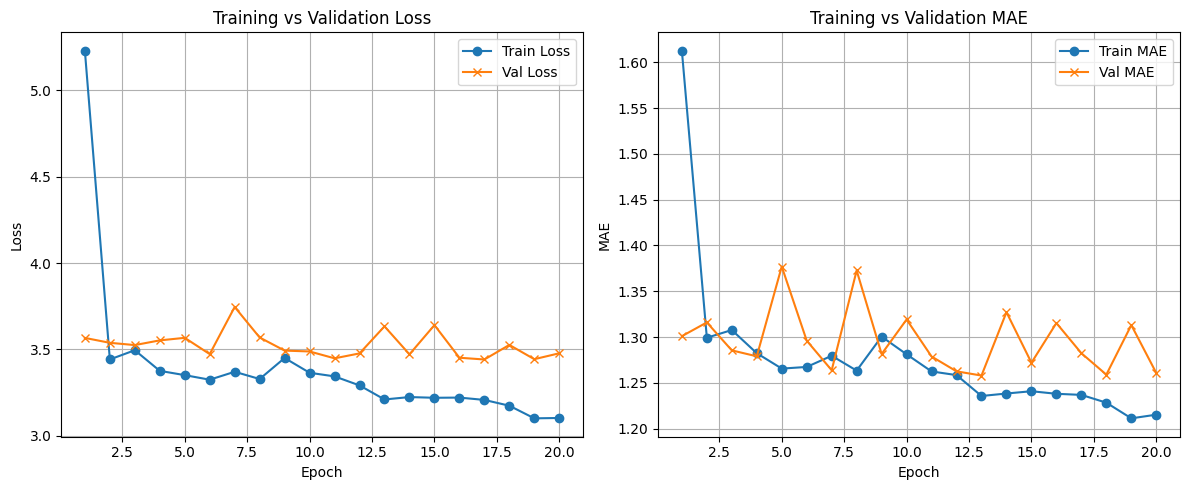

In [6]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training data
train_loss = [
    5.2303, 3.4423, 3.4958, 3.3763, 3.3515, 3.3251, 3.3710, 3.3290, 3.4508, 3.3652,
    3.3443, 3.2920, 3.2106, 3.2245, 3.2204, 3.2215, 3.2080, 3.1744, 3.1013, 3.1034
]
val_loss = [
    3.5671, 3.5387, 3.5256, 3.5528, 3.5675, 3.4733, 3.7462, 3.5695, 3.4936, 3.4886,
    3.4489, 3.4773, 3.6340, 3.4720, 3.6412, 3.4523, 3.4421, 3.5265, 3.4439, 3.4781
]
train_mae = [
    1.6126, 1.2993, 1.3077, 1.2824, 1.2656, 1.2674, 1.2796, 1.2634, 1.3005, 1.2812,
    1.2625, 1.2585, 1.2357, 1.2384, 1.2409, 1.2381, 1.2369, 1.2284, 1.2113, 1.2153
]
val_mae = [
    1.3010, 1.3160, 1.2855, 1.2790, 1.3770, 1.2961, 1.2638, 1.3727, 1.2815, 1.3192,
    1.2788, 1.2626, 1.2580, 1.3272, 1.2720, 1.3153, 1.2824, 1.2590, 1.3131, 1.2608
]

# Plotting
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='x', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1,2,2)
plt.plot(epochs, train_mae, marker='o', label='Train MAE')
plt.plot(epochs, val_mae, marker='x', label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()